# 使用Hugging Face上的預訓練模型做情緒分類

## 試用模型

In [1]:
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import torch

tokenizer=BertTokenizer.from_pretrained('IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment')
model=BertForSequenceClassification.from_pretrained('IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment')

text='今天心情不好'

output=model(torch.tensor([tokenizer.encode(text)]))
print(torch.nn.functional.softmax(output.logits,dim=-1))

/Users/owo/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[0.9551, 0.0449]], grad_fn=<SoftmaxBackward0>)


## 載入資料

In [2]:
import pandas as pd

df = pd.read_csv("ChnSentiCorp_htl_all.csv")
df['label'] = df['label'].map({1:"正面", 0:"負面"}) # 將label欄位轉成標籤
df = df.dropna(subset=["review"]) # 移除空的評論
df = df[df["review"].str.len() < 200] # 移除太長的評論
print(df["label"].value_counts())
df

label
正面    4624
負面    1823
Name: count, dtype: int64


,label,review
0,正面,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,正面,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,正面,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,正面,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,正面,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"
...,...,...
7761,負面,尼斯酒店的几大特点：噪音大、环境差、配置低、服务效率低。如：1、隔壁歌厅的声音闹至午夜3点许...
7762,負面,盐城来了很多次，第一次住盐阜宾馆，我的确很失望整个墙壁黑咕隆咚的，好像被烟熏过一样家具非常的...
7763,負面,看照片觉得还挺不错的，又是4星级的，但入住以后除了后悔没有别的，房间挺大但空空的，早餐是有但...
7764,負面,我们去盐城的时候那里的最低气温只有4度，晚上冷得要死，居然还不开空调，投诉到酒店客房部，得到...


In [3]:
df["len"] = df["review"].apply(lambda x: len(x)) # 計算每個評論的長度
df["len"].describe() # 計算長度的統計數據

count    6447.000000
mean       79.898247
std        47.197480
min         2.000000
25%        40.000000
50%        69.000000
75%       112.000000
max       199.000000
Name: len, dtype: float64

## 預測情緒

In [4]:
# 對資料進行取樣，用正負各200筆測試
df_sample = pd.concat([
    df[df["label"] == "正面"].sample(200, random_state=42),
    df[df["label"] == "負面"].sample(200, random_state=42)
], ignore_index=True) 

df_sample

,label,review,len
0,正面,去年出差时就住过中州，当时带客户去的，感觉不错。所以今年出差又选这家了。,36
1,正面,"原先订豪华房,获提升至行政房,看似分别不大,只是多了一份早餐,但在行政楼层内的早餐非常简单,...",141
2,正面,非常喜欢这家酒店。虽然离中心城区有一点距离，不过因为城市不大，这点距离根本不觉得什么。是花园...,126
3,正面,酒店还比较理想，但是到餐厅就餐不太方便，如果从停车场至大堂有引导标识、客房的灯光亮一些、服务...,84
4,正面,几乎是在凌晨才到的包头，包头也没有什么特别好的酒店，每次来了就是住在这家，所以也没有忒多的对...,63
...,...,...,...
395,負面,酒店位置就在火车站对面，车流密集，环境也很嘈杂，不适合女士前往。入住时，要注明住贵宾楼的，房...,74
396,負面,我要强烈投诉，携程的接线小姐电话里说，这间酒店客人反应很好，我们才入住。谁知道入住，这里的条...,65
397,負面,我那天用信用卡作了担保，订26号凌晨的大床房，事先说明了入住的时间的。结果，到达酒店的时候，...,135
398,負面,酒店的位置还比较方便，但是过于嘈杂，酒店的设施也太陈旧，大床和标准床无太大区别。,40


In [5]:
# 將模型分類的結果轉換為正負面情緒的標籤
def get_sentiment_label(text):
    output=model(torch.tensor([tokenizer.encode(text)]))
    label = torch.argmax(torch.nn.functional.softmax(output.logits,dim=-1))
    return ['負面','正面'][label]

In [6]:
from tqdm import tqdm
tqdm.pandas()
df_sample["predict"] = df_sample["review"].progress_apply(get_sentiment_label)

100%|██████████| 400/400 [00:26<00:00, 14.94it/s]


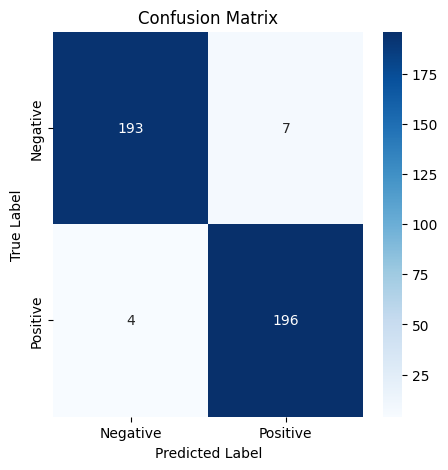

In [7]:
# 繪製混淆矩陣
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_sample["label"], df_sample["predict"])

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks([0.5, 1.5], ["Negative", "Positive"])
plt.yticks([0.5, 1.5], ["Negative", "Positive"])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
